#### Libraries

In [83]:
import yfinance as yfinance
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import pandas as pd
import numpy as np
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose

#### Load Time Series Data


In [84]:
stock_data = yfinance.download('AAPL', start='2024-01-01')
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2024-01-02,184.734970,187.521323,182.993502,186.237603,82488700
2024-01-03,183.351761,184.973819,182.535751,183.321908,58414500
2024-01-04,181.023163,182.197403,179.998185,181.261983,71983600
2024-01-05,180.296707,181.869006,179.291637,181.102771,62303300
2024-01-08,184.655365,184.695178,180.615161,181.202281,59144500


#### Stationarity Tests

In [85]:
def adf_test(series):
    adf_test = adfuller(series)
    # print('ADF Statistic: ', adf_test[0])
    # print('p-value: ', adf_test[1])
    # print('Critical Values:')
    # for key, value in adf_test[4].items():
    #     print('\t%s: %.3f' % (key, value))
    return adf_test

In [86]:
def kpss_test(series):
    kpss_test = kpss(series, regression='ct')
    # print('KPSS Statistic: ', kpss_test[0])
    # print('p-value: ', kpss_test[1])
    # print('Critical Values:')
    # for key, value in kpss_test[3].items():
    #     print('\t%s: %.3f' % (key, value))
    return kpss_test

In [87]:
prices = stock_data['Close']
print(adf_test(prices),"\n\n",
kpss_test(prices))

(np.float64(-0.7553625524907299), np.float64(0.8318837627455178), 0, 257, {'1%': np.float64(-3.4560535712549925), '5%': np.float64(-2.8728527662442334), '10%': np.float64(-2.5727985212493754)}, np.float64(1206.3434547480838)) 

 (np.float64(0.1890066551744623), np.float64(0.020122504309576635), 10, {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})


#### Differencing

In [88]:
first_order_diff = prices.diff().dropna()
pd.concat([prices, first_order_diff], axis=1).head()

Ticker,AAPL,AAPL
Date,,
2024-01-02,184.734970,NaN
2024-01-03,183.351761,-1.383209
2024-01-04,181.023163,-2.328598
2024-01-05,180.296707,-0.726456
2024-01-08,184.655365,4.358658


In [89]:
second_order_diff = first_order_diff.diff().dropna()
pd.concat([prices, first_order_diff, second_order_diff], axis=1).head()

Ticker,AAPL,AAPL,AAPL
Date,,,
2024-01-02,184.734970,NaN,NaN
2024-01-03,183.351761,-1.383209,NaN
2024-01-04,181.023163,-2.328598,-0.945389
2024-01-05,180.296707,-0.726456,1.602142
2024-01-08,184.655365,4.358658,5.085114


#### Transformation

In [90]:
# Log transformation
prices_log = np.log(prices)

# Square root transformation
prices_sqrt = np.sqrt(prices)

# Box-Cox transformation
prices_boxcox, lam = stats.boxcox(prices[prices > 0].values.flatten())  # All positives and 1D array

#### De-Trending

In [91]:
trend = np.polyfit(np.arange(len(prices)), prices, 1)
trend_line = np.polyval(trend, np.arange(len(prices)))
prices_detrended = prices.values.flatten()-trend_line

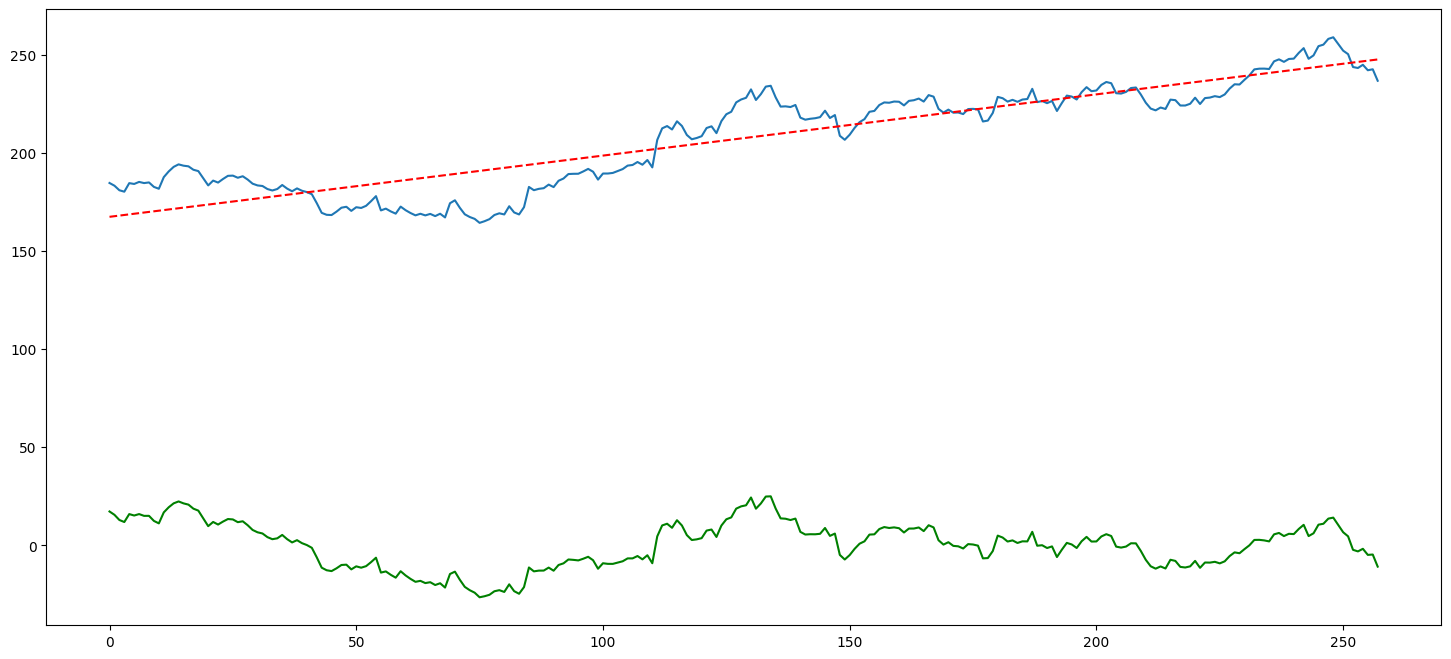

In [92]:
plt.figure(figsize = (18,8))
plt.plot(np.arange(len(prices)), prices, label="Prices")
plt.plot(np.arange(len(prices)), trend_line, label="Trend Line", linestyle="--", color="red")
plt.plot(np.arange(len(prices)), prices_detrended, label="Detrended Prices", color="green")

#### Moving Average

In [93]:
window = 10
prices_ma = prices.rolling(window=window).mean()
prices_ma_detrended = prices.values.flatten() - prices_ma.values.flatten()
prices_ma_detrended = prices_ma_detrended[~np.isnan(prices_ma_detrended)]

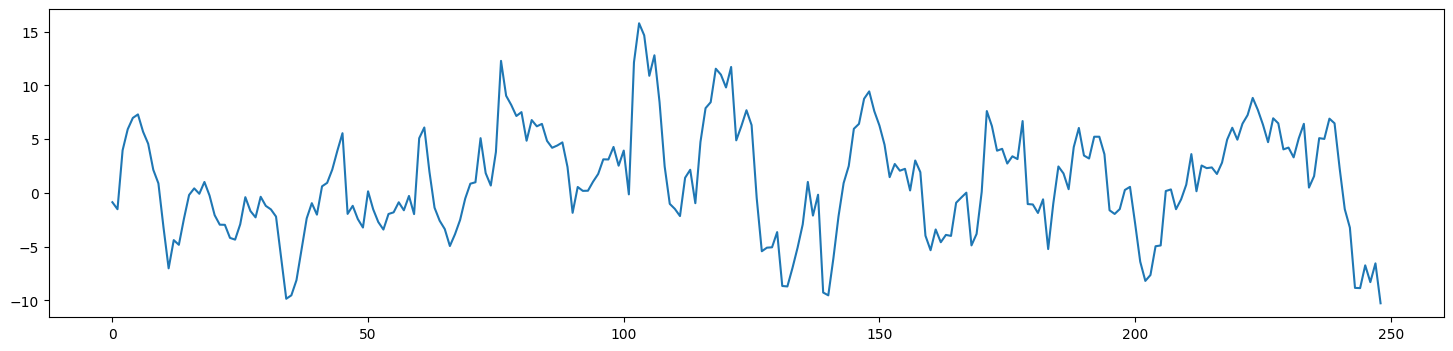

In [94]:
plt.figure(figsize = (18,4))
plt.plot(np.arange(len(prices_ma_detrended)), prices_ma_detrended, label="Prices")

#### Seasonal Decompose

In [101]:
decomposition = seasonal_decompose(prices.values.flatten(), model='additive', period=30)
prices_seasonal_adjusted = prices.values.flatten()/decomposition.seasonal
prices_seasonal_adjusted = prices_seasonal_adjusted[~np.isnan(prices_seasonal_adjusted)]

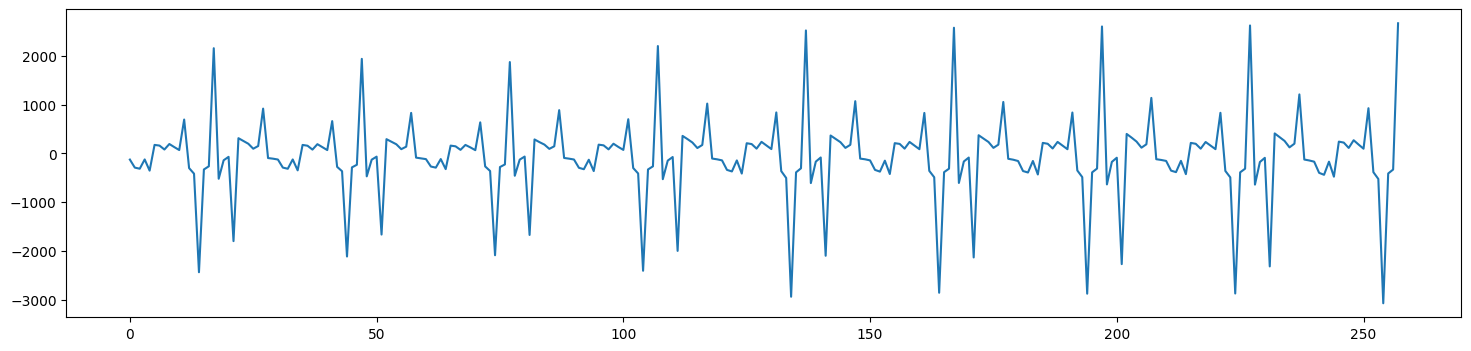

In [104]:
plt.figure(figsize = (18,4))
plt.plot(np.arange(len(prices_seasonal_adjusted)), prices_seasonal_adjusted, label="Prices")

#### Checking Stationary

In [103]:
print("First Order Differencing")
print("ADF Test: ", adf_test(first_order_diff) [1] < 0.05)
print("KPSS Test: ", kpss_test(first_order_diff) [1] >0.05)

print("\n\nSecond Order Differencing")
print("ADF Test: ", adf_test(second_order_diff) [1] < 0.05)
print("KPSS Test: ", kpss_test(second_order_diff) [1] >0.05)

print("\n\nLog Transformation")
print("ADF Test: ", adf_test(prices_log) [1] < 0.05)
print("KPSS Test: ", kpss_test(prices_log) [1] >0.05)

print("\n\nSquare Root Transformation")
print("ADF Test: ", adf_test(prices_sqrt) [1] < 0.05)
print("KPSS Test: ", kpss_test(prices_sqrt) [1] >0.05)

print("\n\nBox-Cox Transformation")
print("ADF Test: ", adf_test(prices_boxcox) [1] < 0.05)
print("KPSS Test: ", kpss_test(prices_boxcox) [1] >0.05)

print("\n\nLinear De-Trending")
print("ADF Test: ", adf_test(prices_detrended) [1] < 0.05)
print("KPSS Test: ", kpss_test(prices_detrended) [1] >0.05)

print("\n\nMoving Average De-Trending")
print("ADF Test: ", adf_test(prices_ma_detrended) [1] < 0.05)
print("KPSS Test: ", kpss_test(prices_ma_detrended) [1] > 0.05)

print("\n\nSeasonal Adjustment")
print("ADF Test: ", adf_test(prices_seasonal_adjusted) [1] < 0.05)
print("KPSS Test: ", kpss_test(prices_seasonal_adjusted) [1] > 0.05)

First Order Differencing
ADF Test:  True
KPSS Test:  True


Second Order Differencing
ADF Test:  True
KPSS Test:  True


Log Transformation
ADF Test:  False
KPSS Test:  False


Square Root Transformation
ADF Test:  False
KPSS Test:  False


Box-Cox Transformation
ADF Test:  False
KPSS Test:  False


Linear De-Trending
ADF Test:  False
KPSS Test:  False


Moving Average De-Trending
ADF Test:  True
KPSS Test:  True


Seasonal Adjustment
ADF Test:  True
KPSS Test:  True
